In [1]:
import glob
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Conv2D, UpSampling2D, InputLayer, Dense, UpSampling3D, Conv3D, AveragePooling2D
from tensorflow.keras import layers
from keras.models import Model
from keras.optimizers import SGD
from skimage.color import lab2rgb, rgb2lab

In [2]:
images_glob = glob.glob('/home/mario/projects/final-project/image-datasets/unlabeled2017_subsample/*.jpg')
images_glob = images_glob[:1200]

images = np.array([np.array(load_img(img_path)) / 255 for img_path in images_glob])
done = "done loading data"
done

'done loading data'

In [3]:
def normalize_lab(img):
  return (img + [0, 128, 128])/[100, 255, 255]

def denormalize_lab(img):
  return (img * [100, 255, 255]) - [0, 128, 128]

def convert_rgb_to_lab(img):
  return normalize_lab(rgb2lab(img))

def convert_lab_to_rgb(img):
  return lab2rgb(denormalize_lab(img))

def extract_grayscalergb_from_lab(image):
  bw = np.zeros(image.shape)

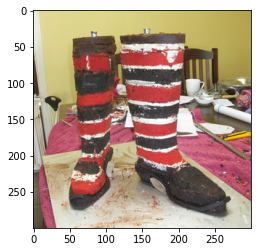

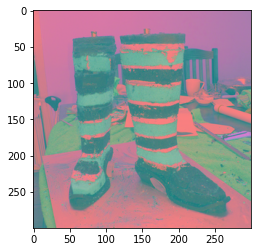

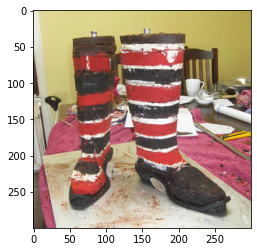

(1200, 300, 300, 3)
(1200, 300, 300, 3)


'done converting to grayscale'

In [4]:
#actually convert to LAB and scale according to L*a*b format values range
lab_images = np.array([convert_rgb_to_lab(img) for img in images])

plt.figure(1)
plt.imshow(images[101], cmap='gray')
plt.figure(2)
plt.imshow(lab_images[101])
plt.figure(3)
#
plt.imshow(convert_lab_to_rgb(lab_images[101]), cmap='gray')
plt.show()

print(images.shape)
print(lab_images.shape)

done = 'done converting to grayscale'
done

In [5]:
IMG_WIDTH = 300
IMG_HEIGHT = 300
# We will predict the a*b layers from the L layer of LAB formatted image
inputs = np.array(lab_images[:, :, :, 0]).reshape(len(lab_images), IMG_WIDTH, IMG_HEIGHT, 1)
outputs = np.array(lab_images[:, :, :, 1:]).reshape(len(lab_images), IMG_WIDTH, IMG_HEIGHT, 2)

# split is 70 * 30 for training. Set to 95 * 5 for actual testing
train_X, test_X, train_y, test_y = train_test_split(inputs, outputs, train_size=0.70)

test_X, test_y = np.array(test_X), np.array(test_y)

done = 'done splitting data'
done

'done splitting data'

In [7]:
resnet = ResNet50(weights='imagenet', include_top=False)

In [ ]:
# Create working prediction model

# TODO: add imagenet layer and freeze
# TODO: add CAM by getting Conv2D in the middle, summing them up elementwise and plotting over original input.

model = Sequential()
model.add(InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)))
model.add(UpSampling3D((2, 2, 3)))
model.add(resnet)
model.add(UpSampling2D((4, 4)))
model.layers[-1].trainable = False
model.add(Conv2D(8, (4, 4), activation='relu', padding='valid', strides=2))
model.add(Conv2D(16, (4, 4), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((3, 3)))
model.add(Conv2D(16, (2, 2), activation='relu', padding='same'))
model.add(UpSampling2D((5, 5)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.summary()
print('done creating layer stack')

model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy', 'val_accuracy'])
print('done compiling...')
model.fit(x=train_X, y=train_y, batch_size=3, epochs=25, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling3d (UpSampling3D) (None, 600, 600, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 76, 76, 2048)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 37, 37, 8)         262152    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 16)        2064      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 32)        4

In [ ]:
model.evaluate(test_X, test_y)

visual_test_idx = 35

test_pred = model.predict(np.array([inputs[visual_test_idx]]))

predicted_LAB = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3))
predicted_LAB[:, :, 0] = inputs[visual_test_idx][:, :, 0]
predicted_LAB[:, :, 1:] = test_pred[0]
predicted_RGB = convert_lab_to_rgb(predicted_LAB)

plt.figure(4)
plt.imshow(predicted_RGB)
plt.show()

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)))
model.add(UpSampling3D((2, 2, 3)))
model.add(ResNet50(weights='imagenet', include_top=False))
model.add(UpSampling2D((4, 4)))
model.layers[-1].trainable = False
model.add(Conv2D(8, (4, 4), activation='relu', padding='valid', strides=2))
model.add(Conv2D(16, (4, 4), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((3, 3)))
model.add(Conv2D(16, (2, 2), activation='relu', padding='same'))
model.add(UpSampling2D((5, 5)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.summary()

model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy', 'val_accuracy'])
model.fit(x=train_X, y=train_y, batch_size=5, epochs=80, verbose=1)
